In [1]:
# tutorial from https://huggingface.co/docs/transformers/en/model_doc/vitpose
#from transformers.models.vitpose import VitPoseForPoseEstimation, VitPoseImageProcessor
from transformers import AutoProcessor, RTDetrForObjectDetection, VitPoseForPoseEstimation
import torch
import requests
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2

In [2]:
path2vid = "/Volumes/TIZIANO/stimuli/Project1917_movie_part3_24Hz.mp4"
reader = cv2.VideoCapture(path2vid)


In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
person_image_processor = AutoProcessor.from_pretrained("PekingU/rtdetr_r50vd_coco_o365") # loads a preprocessing pipeline img (to ensure same preproc.g)
person_model = RTDetrForObjectDetection.from_pretrained("PekingU/rtdetr_r50vd_coco_o365", device_map=device) # loads the object detection model:  RT-DETR object detection model (detectiion + label.g -> label 0 = person)
#inputs = person_image_processor(images=image, return_tensors="pt").to(device) # preprocesses the image and returns it as a tensor
# returns an object of type <class 'transformers.image_processing_base.BatchFeature'> -> behaves like a dict e.g. inputs.keys() -> 'pixel_values' i.e. the normalized img tensor of shape 2, 3, 256, 192



Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [4]:
for i in range(1):
    ret, frame = reader.read()
    if ret == False:
        break
    # end if ret==False:

    frame_rgb = cv2.cvtColor(
        frame, cv2.COLOR_BGR2RGB
    )  # converts to bgr to rgb color codes
    inputs = person_image_processor(frame_rgb, return_tensors="pt")

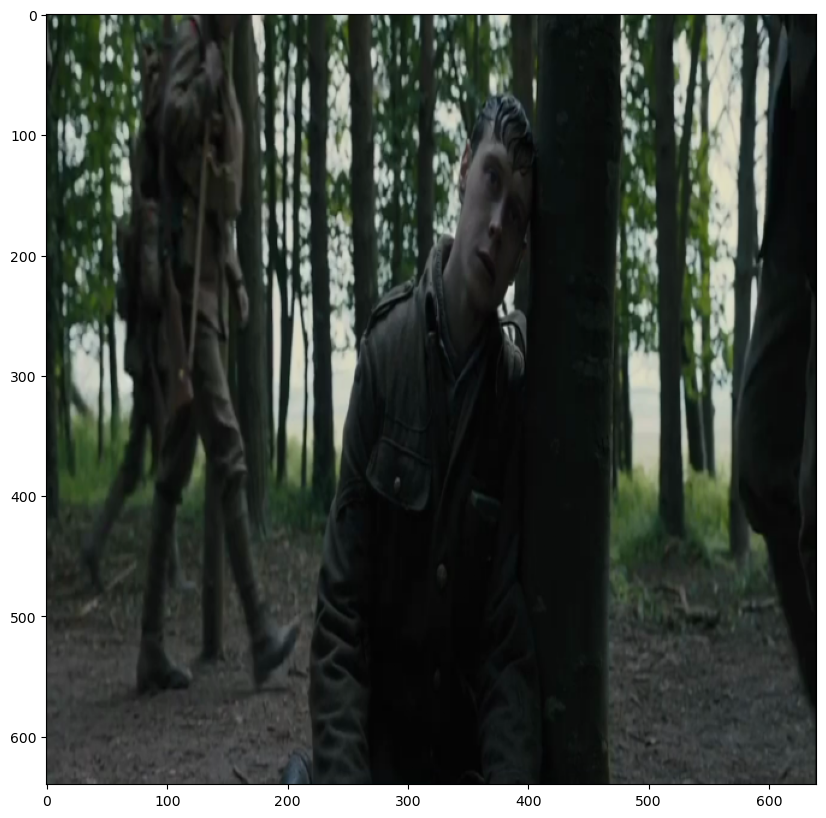

In [5]:
# to see the preprocessed img
img = inputs["pixel_values"][0, :,:,:]
img_np = img.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(10,10))
plt.imshow(img_np)

In [6]:
img_np.shape

(640, 640, 3)

In [7]:
with torch.no_grad():
    outputs = person_model(**inputs) # performs object detection on the input

results = person_image_processor.post_process_object_detection(
    outputs, target_sizes=torch.tensor([(img_np.shape[0], img_np.shape[1])]), threshold=0.3  # converts raw model outputs into interpretable bounding box predictions 
)
    # parameters:
# - (image.height, image.width) -> the original dimensions of the img to rescale the boxes accordingly
# - threshold=.3 -> keeps only the high confidence detections
# results is a list with 1 element, a dict, with the following entries: 
# 'scores' (a tensor with the confidences), 
# 'labels' (a tensor with the lables detected)
# 'boxes' (a tensor with the boxes corners)

result = results[0] # selects the first element in the list
person_boxes = result["boxes"][result["labels"] == 0] # index only the boxes associated with label 0 (person) in COCO class labels
person_boxes = person_boxes.cpu().numpy() # converts them to numpy
# converts boxes from VOC format: (x1, y1, x2, y2) to COCO format: N pers detected x 4 -> 4 cols are => (x, y, width, height)
person_boxes[:, 2] = person_boxes[:, 2] - person_boxes[:, 0] 
person_boxes[:, 3] = person_boxes[:, 3] - person_boxes[:, 1] 

In [8]:
outputs.keys()

odict_keys(['logits', 'pred_boxes', 'last_hidden_state', 'intermediate_hidden_states', 'intermediate_logits', 'intermediate_reference_points', 'encoder_last_hidden_state', 'init_reference_points', 'enc_topk_logits', 'enc_topk_bboxes', 'enc_outputs_class', 'enc_outputs_coord_logits'])

In [9]:
print(person_boxes)

[[ 2.01992111e+02  6.45799255e+01  2.11486893e+02  5.72945068e+02]
 [ 7.12359924e+01  1.93424225e-01  1.39863068e+02  5.66898621e+02]
 [ 5.69400696e+02 -6.23779297e-01  7.05755615e+01  6.01606689e+02]
 [ 2.94961128e+01  1.55069351e+00  1.00755936e+02  5.49208313e+02]]


In [10]:
result

{'scores': tensor([0.9091, 0.8894, 0.5513, 0.3321]),
 'labels': tensor([0, 0, 0, 0]),
 'boxes': tensor([[ 2.0199e+02,  6.4580e+01,  4.1348e+02,  6.3752e+02],
         [ 7.1236e+01,  1.9342e-01,  2.1110e+02,  5.6709e+02],
         [ 5.6940e+02, -6.2378e-01,  6.3998e+02,  6.0098e+02],
         [ 2.9496e+01,  1.5507e+00,  1.3025e+02,  5.5076e+02]])}

In [11]:
# ------------------------------------------------------------------------
# Stage 2. Detect keypoints for each person found
# ------------------------------------------------------------------------

image_processor = AutoProcessor.from_pretrained("usyd-community/vitpose-base-simple") # downloads a processor tailored for the vitpose-base-simple model, it resizes, normalizes, and formats input data (cropping each detected person), automatically includes COCO keypoint configuration.
model = VitPoseForPoseEstimation.from_pretrained("usyd-community/vitpose-base-simple", device_map=device) #downloads ViTPose

inputs = image_processor(frame_rgb, boxes=[person_boxes], return_tensors="pt").to(device) # processes the original image using the bounding boxes -> ViTPose expects tightly cropped pics
# inputs is a dict like type with "pixels_value" as only entry. It is a tensor [Batch, Channels, Height, Width] -> Batch is the number of people detected

with torch.no_grad():
    outputs = model(**inputs) # runs ViTPose

pose_results = image_processor.post_process_pose_estimation(outputs, boxes=[person_boxes]) 
# pose results is a list (len=1, num of images passed) of lists (len=Batch_size=people detected). 
# Each element is a dict with:
# - 'keypoints' -> the 2d coords of the keypoints within the img ref frame
# - 'scores' -> the confidence of each of the keypoints
# - 'labels' -> the labels of the keypoints , model.config.label2id to see the correspondence 
# - 'bbox' -> contours of the boxes 

image_pose_result = pose_results[0]  

In [12]:
torch.Tensor.size(inputs["pixel_values"])

torch.Size([4, 3, 256, 192])

In [13]:
print(pose_results[0][0])
print(len(pose_results[0]))

{'keypoints': tensor([[309.5776, -12.2549],
        [312.6615, -12.7240],
        [308.3941, -12.6499],
        [297.7403, -13.1703],
        [290.4533, -12.7234],
        [291.4245,  32.3918],
        [241.7296,  17.5043],
        [301.6776, 123.1084],
        [217.7506,  80.5003],
        [311.3739, 179.2353],
        [275.0916,  46.9575],
        [266.8146, 201.4833],
        [238.2275, 201.9312],
        [205.9258, 317.5672],
        [309.7995, 300.7354],
        [172.1901, 433.2736],
        [359.5755, 423.8371]]), 'scores': tensor([0.4377, 0.3260, 0.3413, 0.3219, 0.4870, 0.6743, 0.9251, 0.7880, 0.9215,
        0.9186, 0.8616, 0.7226, 0.7830, 0.8576, 0.9506, 0.8532, 0.8840]), 'labels': tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]), 'bbox': tensor([307.7356, 351.0525, 309.4212, 353.6334])}
4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


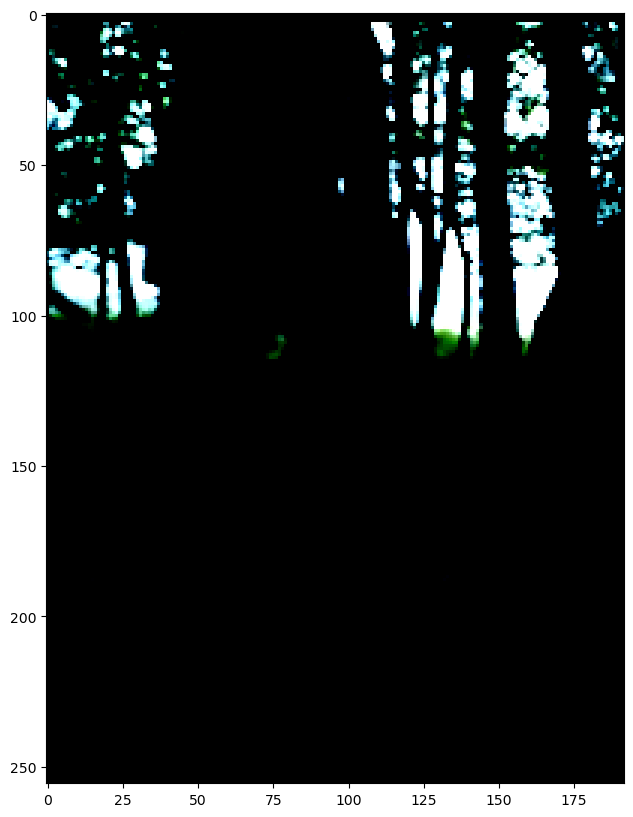

In [14]:
# to see what are the inputs to the model
img = inputs["pixel_values"][0, :,:,:]
img_np = img.permute(1, 2, 0).cpu().numpy()
plt.figure(figsize=(10,10))
plt.imshow(img_np)

In [61]:
torch.Tensor.size(inputs["pixel_values"])

torch.Size([4, 3, 256, 192])

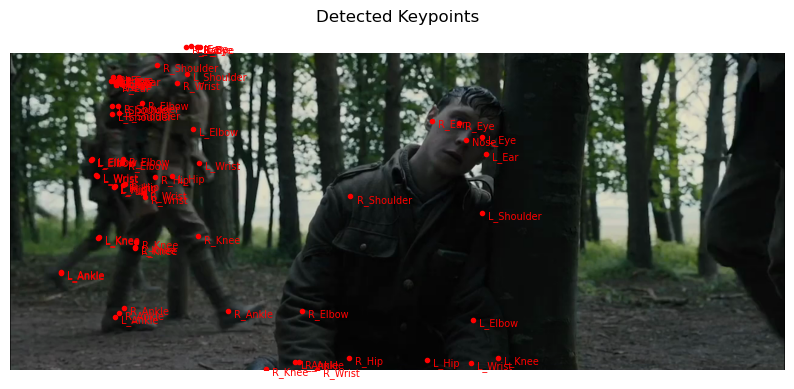

In [16]:
def plot_pose(image, boxes, img_pose_res, pers_indices, model):
    keypoint_labels = model.config.label2id 
    label_names = {v: k for k, v in keypoint_labels.items()} # reverts keys and vals of the labels so that we can retrieve properly the label names
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    for pers_idx in pers_indices:
        box = boxes[pers_idx]
        keypoints = img_pose_res[pers_idx]["keypoints"]
        labels_kp = img_pose_res[pers_idx]["labels"]
        for kp_idx in range(keypoints.size()[0]):
            kps = keypoints[kp_idx, :].numpy()
            plt.plot(kps[0], kps[1], 'ro', markersize=3)
            plt.text(kps[0]+10, kps[1]+10, label_names[labels_kp[kp_idx].item()], color="red", fontsize=7)
        # # Optionally draw bounding box
        # x, y, w, h = box
        # rect = plt.Rectangle((x, y), w, h, edgecolor='green', facecolor='none', linewidth=1)
        # plt.gca().add_patch(rect)
    
    plt.axis('off')
    plt.title("Detected Keypoints")
    plt.show()

plot_pose(frame_rgb, person_boxes, image_pose_result, [0,1,2], model)

In [29]:
model.config.label2id 

{'L_Ankle': 15,
 'L_Ear': 3,
 'L_Elbow': 7,
 'L_Eye': 1,
 'L_Hip': 11,
 'L_Knee': 13,
 'L_Shoulder': 5,
 'L_Wrist': 9,
 'Nose': 0,
 'R_Ankle': 16,
 'R_Ear': 4,
 'R_Elbow': 8,
 'R_Eye': 2,
 'R_Hip': 12,
 'R_Knee': 14,
 'R_Shoulder': 6,
 'R_Wrist': 10}

In [ ]:
image_pose_result[0]["keypoints"].size()[0]

In [ ]:
person_boxes